# **Twitter Sentiment Analysis on ChatGPT**

## Data Preparation

In [1]:
#Importing all the neccessary libraries
import pandas as pd
import numpy as np

#Libraries for visualisation
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

#Libraries for formattting and handling text 
import string
import re

#Library for nltk
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk import WordNetLemmatizer
from nltk import word_tokenize
from textblob import TextBlob
from nltk.sentiment.vader import SentimentIntensityAnalyzer

from collections import Counter
from wordcloud import WordCloud

import warnings
warnings.filterwarnings("ignore")

In [2]:
import plotly
plotly.offline.init_notebook_mode (connected = True)

### Import Dataset

In [3]:
#Loading the required data
df=pd.read_csv('/kaggle/input/chatgpt-twitter/chatgpt.csv')
df.head()

,tweet_id,created_at,like_count,quote_count,reply_count,retweet_count,tweet,country,photo_url,city,country_code
0,1598014056790622225,2022-11-30 18:00:15+00:00,2,0,0,0,ChatGPT: Optimizing Language Models for Dialog...,NaN,NaN,NaN,NaN
1,1598014522098208769,2022-11-30 18:02:06+00:00,12179,889,1130,3252,"Try talking with ChatGPT, our new AI system wh...",NaN,NaN,NaN,NaN
2,1598014741527527435,2022-11-30 18:02:58+00:00,2,0,0,1,ChatGPT: Optimizing Language Models for Dialog...,NaN,https://pbs.twimg.com/media/Fi1J8HbWAAMv_yi.jpg,NaN,NaN
3,1598015493666766849,2022-11-30 18:05:58+00:00,561,8,25,66,"THRILLED to share that ChatGPT, our new model ...",NaN,https://pbs.twimg.com/media/Fi1Km3WUYAAfzHS.jpg,NaN,NaN
4,1598015509420994561,2022-11-30 18:06:01+00:00,1,0,0,0,"As of 2 minutes ago, @OpenAI released their ne...",NaN,NaN,NaN,NaN


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 219294 entries, 0 to 219293
Data columns (total 11 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   tweet_id       219294 non-null  int64 
 1   created_at     219294 non-null  object
 2   like_count     219294 non-null  int64 
 3   quote_count    219294 non-null  int64 
 4   reply_count    219294 non-null  int64 
 5   retweet_count  219294 non-null  int64 
 6   tweet          219294 non-null  object
 7   country        3648 non-null    object
 8   photo_url      68446 non-null   object
 9   city           3648 non-null    object
 10  country_code   3645 non-null    object
dtypes: int64(5), object(6)
memory usage: 18.4+ MB


### Checking null values

In [5]:
df.isnull().sum()

tweet_id              0
created_at            0
like_count            0
quote_count           0
reply_count           0
retweet_count         0
tweet                 0
country          215646
photo_url        150848
city             215646
country_code     215649
dtype: int64

### Removing columns with null values

In [6]:
df=df.drop(['country','photo_url','city','country_code'],axis=1)
df.head()

,tweet_id,created_at,like_count,quote_count,reply_count,retweet_count,tweet
0,1598014056790622225,2022-11-30 18:00:15+00:00,2,0,0,0,ChatGPT: Optimizing Language Models for Dialog...
1,1598014522098208769,2022-11-30 18:02:06+00:00,12179,889,1130,3252,"Try talking with ChatGPT, our new AI system wh..."
2,1598014741527527435,2022-11-30 18:02:58+00:00,2,0,0,1,ChatGPT: Optimizing Language Models for Dialog...
3,1598015493666766849,2022-11-30 18:05:58+00:00,561,8,25,66,"THRILLED to share that ChatGPT, our new model ..."
4,1598015509420994561,2022-11-30 18:06:01+00:00,1,0,0,0,"As of 2 minutes ago, @OpenAI released their ne..."


## Feature Extraction

In [8]:
data=df.copy()

### Number of words

In [9]:
def number_of_words(data):
    data['word_count'] = data['tweet'].apply(lambda x : len(str(x).split(" ")))

 ### Number of characters 

In [10]:
def char_count(text):
    charc=0
    for char in text.split():
        charc +=len(char)
    return charc

### Number of stopwords

In [11]:
stop_words = stopwords.words('english')

def num_of_stopwords(data):
    data['stopwords_count'] = data['tweet'].apply(lambda x: len([x for x in x.split() if x in stop_words]))

 ### Number of hashtags 

In [12]:
def num_of_hashtags(data):
    data['hashtag_count'] = data['tweet'].apply(lambda x: len([x for x in x.split() if x.startswith('#')]))

 #### Extraction Function 

In [13]:
def feat_extract(data):
    num_of_hashtags(data)
    number_of_words(data)
    data['char_count']=data['tweet'].apply(char_count)
    num_of_stopwords(data)

### Emoji Removal

In [14]:
def remove_emoji(string):
        emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
        return emoji_pattern.sub(r'', string) 


 ### Hyperlink Removal 

In [15]:
def hyperlinks(text):
    temp = re.sub("<[a][^>]*>(.+?)</[a]>", 'Link.',text)
    temp = re.sub(r'http\S+', '', temp)
    temp = re.sub('&gt;', "", temp) # greater than sign
    temp = re.sub('&#x27;', "'", temp) # apostrophe
    temp = re.sub('&#x2F;', ' ', temp)
    temp = re.sub('<p>', ' ', temp) # paragraph tag
    temp = re.sub('<i>', ' ', temp) #italics tag
    temp = re.sub('</i>', '', temp) 
    temp = re.sub('&#62;', '', temp)
    temp = re.sub("\n", '', temp) # newline 
    return temp

 ### Basic cleaning and Stopwords removal

In [16]:
def clean_tweet(tweet):
    temp=tweet.lower()
    temp = re.sub("'", "", temp) # to avoid removing contractions in english
    temp = re.sub("@[A-Za-z0-9_]+","", temp)
    temp = re.sub("chatgpt","",temp)
    temp = re.sub(r'http\S+', '', temp)
    temp = re.sub('[()!?]', ' ', temp)
    temp = re.sub('\[.*?\]',' ', temp)
    punc=string.punctuation
    temp=temp.translate(str.maketrans('','',punc))
    
    #removing stopwords
    new_list=[]
    words=word_tokenize(temp)
    sws=stopwords.words('english')
    for word in words:
        if word not in sws:
            new_list.append(word)
    
    temp=' '.join(new_list)
    return temp

 ### Spelling Correction

In [17]:
def spell_correct(data):
    data['tweet'].apply(lambda x: str(TextBlob(x).correct()))

 ### Lemmatization 

In [18]:
def lemmatize(text):    
    new_list=[]
    lemma=WordNetLemmatizer()
    words=word_tokenize(text)
    for word in words:
        new_list.append(lemma.lemmatize(word))
    
    return ' '.join(new_list)

#### Implementing all the functions 

In [19]:
feat_extract(data)

data['tweet'] = data['tweet'].apply(hyperlinks)
data['tweet'] = data['tweet'].apply(remove_emoji)
data['tweet'] = data['tweet'].apply(clean_tweet)
data['final_tweet'] = data['tweet'].apply(lemmatize)

In [20]:
data.head()

,tweet_id,created_at,like_count,quote_count,reply_count,retweet_count,tweet,hashtag_count,word_count,char_count,stopwords_count,final_tweet
0,1598014056790622225,2022-11-30 18:00:15+00:00,2,0,0,0,optimizing language models dialogue,0,8,73,1,optimizing language model dialogue
1,1598014522098208769,2022-11-30 18:02:06+00:00,12179,889,1130,3252,try talking new ai system optimized dialogue f...,0,21,119,6,try talking new ai system optimized dialogue f...
2,1598014741527527435,2022-11-30 18:02:58+00:00,2,0,0,1,optimizing language models dialogue ai machine...,4,26,239,3,optimizing language model dialogue ai machinel...
3,1598015493666766849,2022-11-30 18:05:58+00:00,561,8,25,66,thrilled share new model optimized dialog publ...,0,22,167,8,thrilled share new model optimized dialog publ...
4,1598015509420994561,2022-11-30 18:06:01+00:00,1,0,0,0,2 minutes ago released new nnand use right,0,20,120,6,2 minute ago released new nnand use right


## Sentiment Analysis

In [21]:
sid=SentimentIntensityAnalyzer()

In [22]:
data['sentiment_compound_polarity']=data.final_tweet.apply(lambda x:sid.polarity_scores(x)['compound'])
data['sentiment_neutral']=data.final_tweet.apply(lambda x:sid.polarity_scores(x)['neu'])
data['sentiment_negative']=data.final_tweet.apply(lambda x:sid.polarity_scores(x)['neg'])
data['sentiment_pos']=data.final_tweet.apply(lambda x:sid.polarity_scores(x)['pos'])
data['sentiment_type']=''

data.loc[data.sentiment_compound_polarity>0,'sentiment_type']='POSITIVE'
data.loc[data.sentiment_compound_polarity==0,'sentiment_type']='NEUTRAL'
data.loc[data.sentiment_compound_polarity<0,'sentiment_type']='NEGATIVE'
data.head()

,tweet_id,created_at,like_count,quote_count,reply_count,retweet_count,tweet,hashtag_count,word_count,char_count,stopwords_count,final_tweet,sentiment_compound_polarity,sentiment_neutral,sentiment_negative,sentiment_pos,sentiment_type
0,1598014056790622225,2022-11-30 18:00:15+00:00,2,0,0,0,optimizing language models dialogue,0,8,73,1,optimizing language model dialogue,0.4588,0.500,0.0,0.500,POSITIVE
1,1598014522098208769,2022-11-30 18:02:06+00:00,12179,889,1130,3252,try talking new ai system optimized dialogue f...,0,21,119,6,try talking new ai system optimized dialogue f...,0.8225,0.449,0.0,0.551,POSITIVE
2,1598014741527527435,2022-11-30 18:02:58+00:00,2,0,0,1,optimizing language models dialogue ai machine...,4,26,239,3,optimizing language model dialogue ai machinel...,0.4588,0.857,0.0,0.143,POSITIVE
3,1598015493666766849,2022-11-30 18:05:58+00:00,561,8,25,66,thrilled share new model optimized dialog publ...,0,22,167,8,thrilled share new model optimized dialog publ...,0.8860,0.345,0.0,0.655,POSITIVE
4,1598015509420994561,2022-11-30 18:06:01+00:00,1,0,0,0,2 minutes ago released new nnand use right,0,20,120,6,2 minute ago released new nnand use right,0.0000,1.000,0.0,0.000,NEUTRAL


## EDA

 ### Plots for Sentiment Analysis 

<AxesSubplot:ylabel='sentiment_type'>

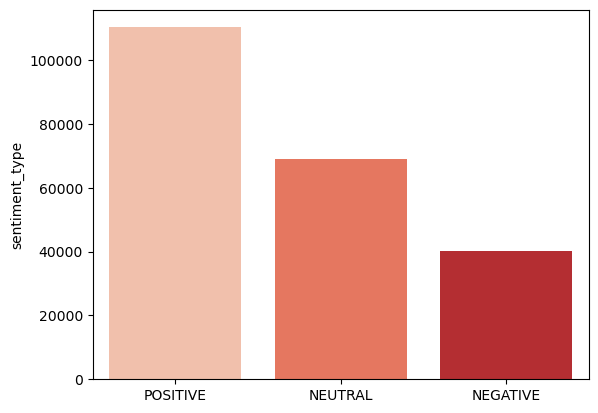

In [23]:
sns.barplot(data=data,x=data['sentiment_type'].value_counts().index,y=data['sentiment_type'].value_counts(),palette='Reds')

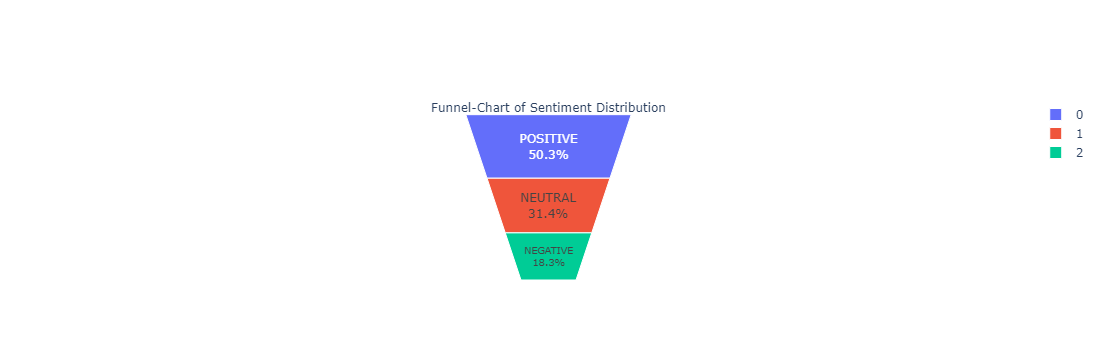

In [24]:
fig = go.Figure(go.Funnelarea(
    text =data['sentiment_type'].value_counts().index,
    values = data['sentiment_type'].value_counts(),
    title = {"position": "top center", "text": "Funnel-Chart of Sentiment Distribution"}
    ))
fig.show()

###  Word-Level EDA

In [25]:
eda=data.copy()

eda['temp_list'] = eda['final_tweet'].apply(lambda x:str(x).split())
top = Counter([item for sublist in eda['temp_list'] for item in sublist])
temp = pd.DataFrame(top.most_common(30))
temp.columns = ['Common_words','count']

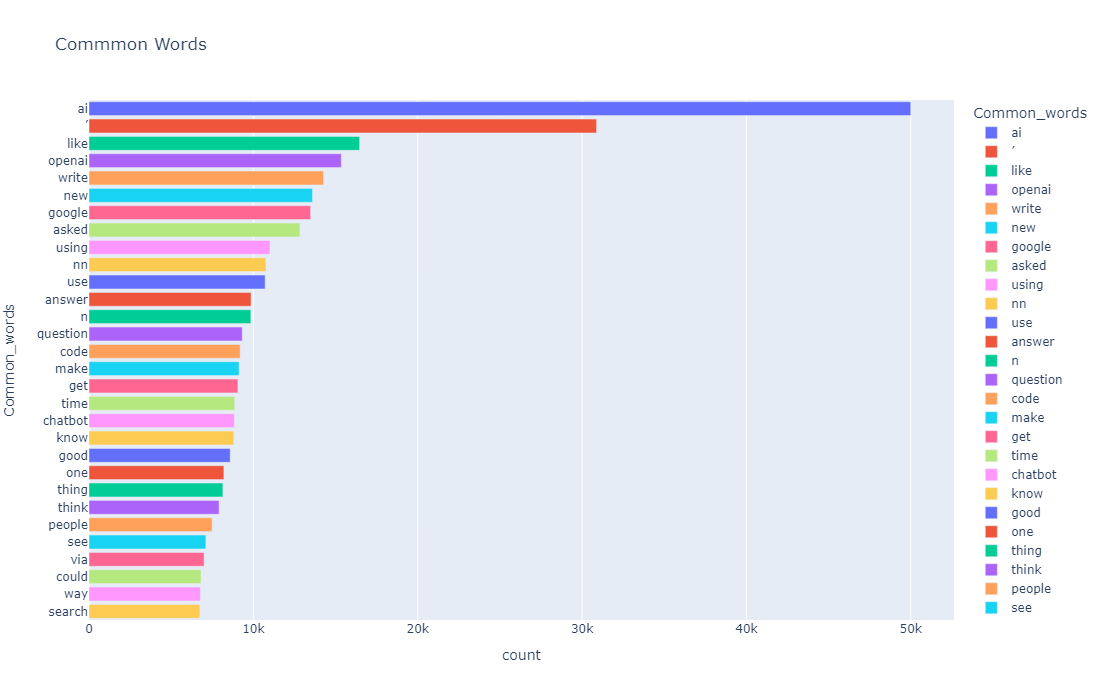

In [26]:
#bar plot using plotly.express
fig = px.bar(temp, x="count", y="Common_words", title='Commmon Words', orientation='h', 
             width=700, height=700,color='Common_words')
fig.show()

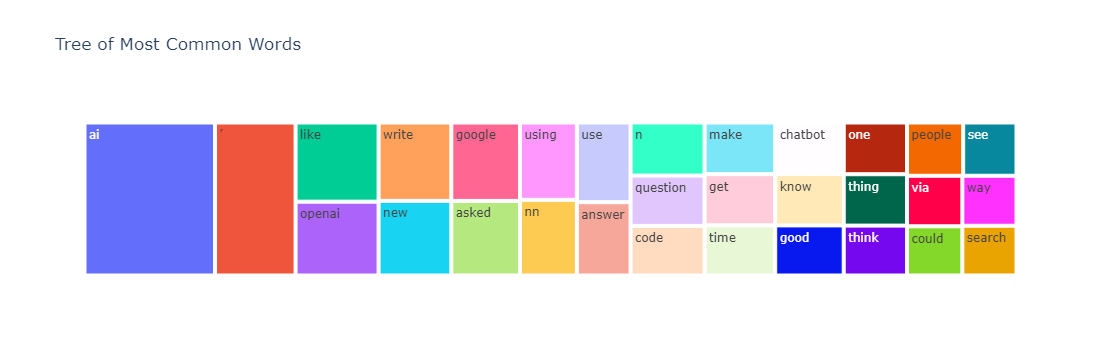

In [27]:
#tree map using plotly.express
fig = px.treemap(temp, path=['Common_words'], values='count',title='Tree of Most Common Words')
fig.show()

### Most Common Words Sentiment wise 

In [28]:
pos=eda[eda['sentiment_type']=='POSITIVE']
neg=eda[eda['sentiment_type']=='NEGATIVE']
neu=eda[eda['sentiment_type']=='NEUTRAL']

### Most Common Positive Words

In [29]:
top = Counter([item for sublist in pos['temp_list'] for item in sublist])
temp_pos = pd.DataFrame(top.most_common(30))
temp_pos.columns = ['Common_words','count']
temp_pos.style.background_gradient(cmap='Greens')

,Common_words,count
0,ai,28593
1,’,18046
2,like,14573
3,openai,8146
4,new,7940
5,write,7677
6,good,7409
7,asked,6996
8,use,6570
9,using,6251


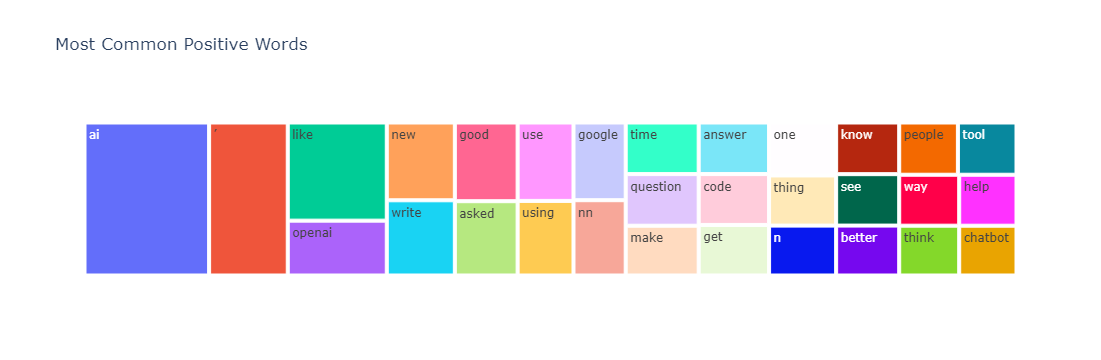

In [30]:
#tree map using plotly.express
fig = px.treemap(temp_pos, path=['Common_words'], values='count',title='Most Common Positive Words')
fig.show()

### Most Common Negative Words

In [31]:
top = Counter([item for sublist in pos['temp_list'] for item in sublist])
temp_neg = pd.DataFrame(top.most_common(30))
temp_neg.columns = ['Common_words','count']
temp_neg.style.background_gradient(cmap='Reds')

,Common_words,count
0,ai,28593
1,’,18046
2,like,14573
3,openai,8146
4,new,7940
5,write,7677
6,good,7409
7,asked,6996
8,use,6570
9,using,6251


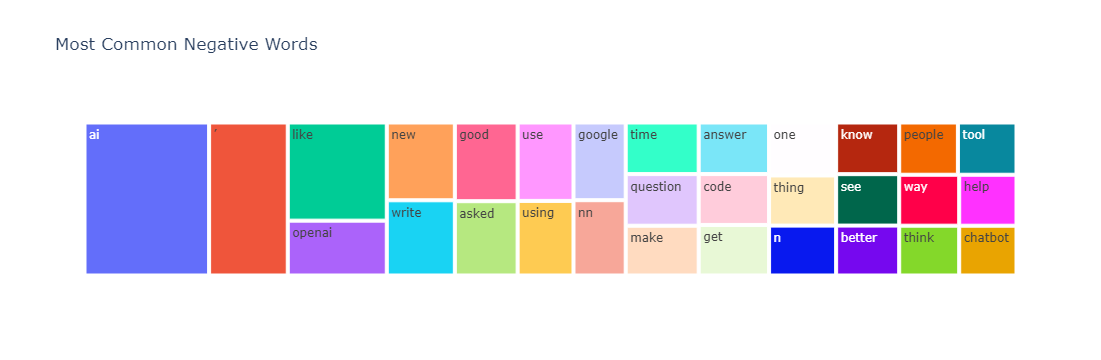

In [32]:
fig = px.treemap(temp_neg, path=['Common_words'], values='count',title='Most Common Negative Words')
fig.show()

## Wordclouds

### For Positive Tweets

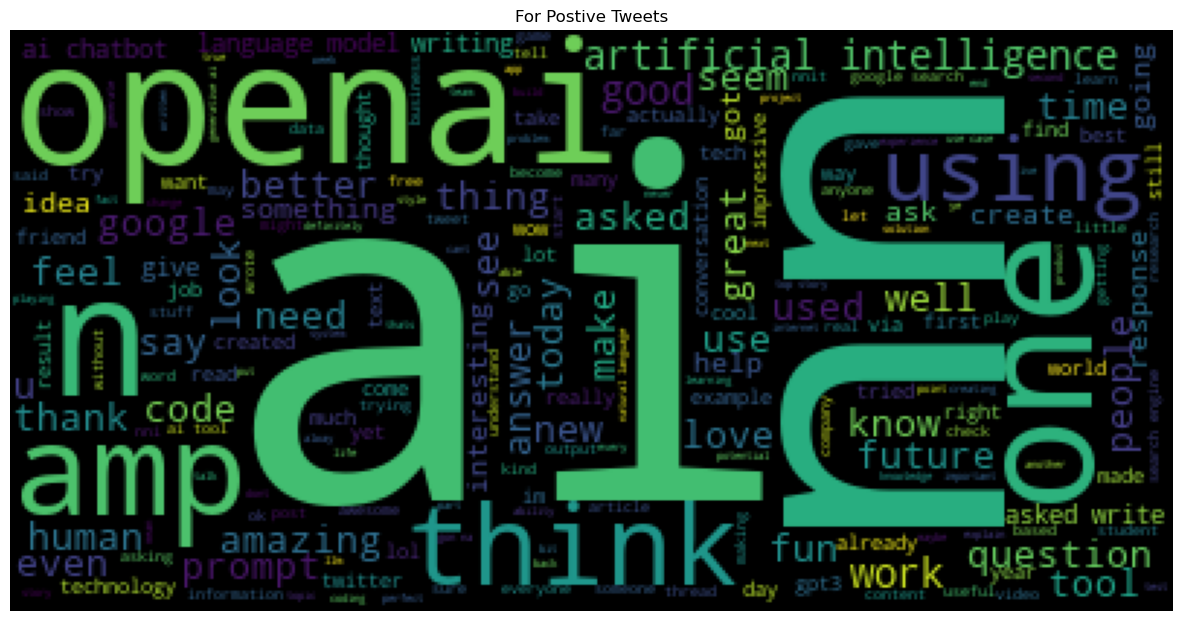

In [33]:
plt.figure(figsize=(15,10))
text=' '.join(eda[eda['sentiment_type']=='POSITIVE']['final_tweet'])
wordcloud=WordCloud(max_words=500,background_color='black',colormap='viridis').generate(text)
plt.imshow(wordcloud)
plt.axis('off')
plt.title('For Postive Tweets')
plt.show()

### For Negative Tweets

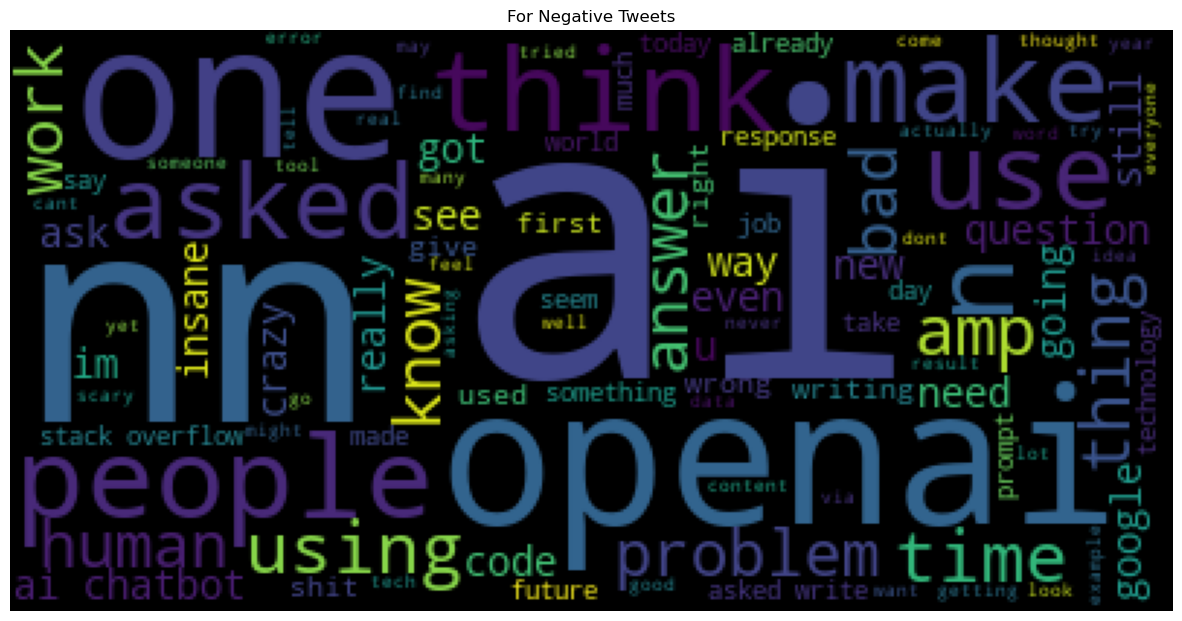

In [34]:
plt.figure(figsize=(15,10))
text=' '.join(eda[eda['sentiment_type']=='NEGATIVE']['final_tweet'])
wordcloud=WordCloud(max_words=100,background_color='black',colormap='viridis').generate(text)
plt.imshow(wordcloud)
plt.axis('off')
plt.title('For Negative Tweets')
plt.show()

In [35]:
data.head()

,tweet_id,created_at,like_count,quote_count,reply_count,retweet_count,tweet,hashtag_count,word_count,char_count,stopwords_count,final_tweet,sentiment_compound_polarity,sentiment_neutral,sentiment_negative,sentiment_pos,sentiment_type
0,1598014056790622225,2022-11-30 18:00:15+00:00,2,0,0,0,optimizing language models dialogue,0,8,73,1,optimizing language model dialogue,0.4588,0.500,0.0,0.500,POSITIVE
1,1598014522098208769,2022-11-30 18:02:06+00:00,12179,889,1130,3252,try talking new ai system optimized dialogue f...,0,21,119,6,try talking new ai system optimized dialogue f...,0.8225,0.449,0.0,0.551,POSITIVE
2,1598014741527527435,2022-11-30 18:02:58+00:00,2,0,0,1,optimizing language models dialogue ai machine...,4,26,239,3,optimizing language model dialogue ai machinel...,0.4588,0.857,0.0,0.143,POSITIVE
3,1598015493666766849,2022-11-30 18:05:58+00:00,561,8,25,66,thrilled share new model optimized dialog publ...,0,22,167,8,thrilled share new model optimized dialog publ...,0.8860,0.345,0.0,0.655,POSITIVE
4,1598015509420994561,2022-11-30 18:06:01+00:00,1,0,0,0,2 minutes ago released new nnand use right,0,20,120,6,2 minute ago released new nnand use right,0.0000,1.000,0.0,0.000,NEUTRAL


 ### Word-Level Analysis 

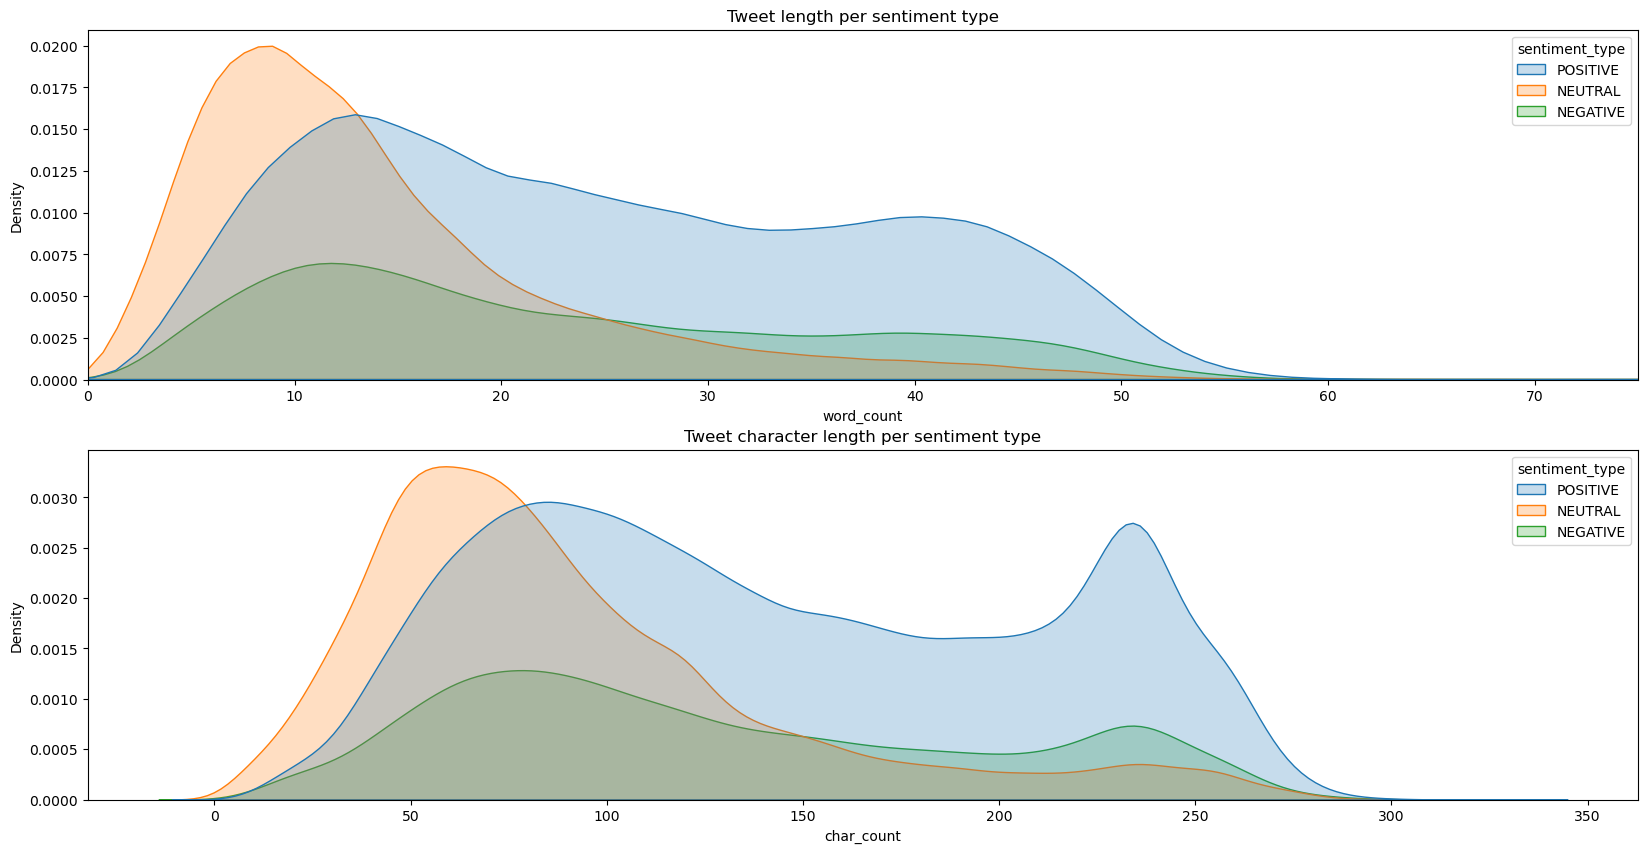

In [36]:
plt.figure(figsize=(20,10))

plt.subplot(2,1,1)
sns.kdeplot(x=data['word_count'],hue=data['sentiment_type'],shade=True)
plt.title('Tweet length per sentiment type')
plt.xlim(0,75)

plt.subplot(2,1,2)
sns.kdeplot(x=data['char_count'],hue=data['sentiment_type'],shade=True)
plt.title('Tweet character length per sentiment type')

plt.show()

## Trend Analysis


In [37]:
datadate=data.copy()

datadate['created_at']=pd.to_datetime(datadate['created_at'])
datadate.set_index('created_at',inplace=True)

datadate.head()

,tweet_id,like_count,quote_count,reply_count,retweet_count,tweet,hashtag_count,word_count,char_count,stopwords_count,final_tweet,sentiment_compound_polarity,sentiment_neutral,sentiment_negative,sentiment_pos,sentiment_type
created_at,,,,,,,,,,,,,,,,
2022-11-30 18:00:15+00:00,1598014056790622225,2,0,0,0,optimizing language models dialogue,0,8,73,1,optimizing language model dialogue,0.4588,0.500,0.0,0.500,POSITIVE
2022-11-30 18:02:06+00:00,1598014522098208769,12179,889,1130,3252,try talking new ai system optimized dialogue f...,0,21,119,6,try talking new ai system optimized dialogue f...,0.8225,0.449,0.0,0.551,POSITIVE
2022-11-30 18:02:58+00:00,1598014741527527435,2,0,0,1,optimizing language models dialogue ai machine...,4,26,239,3,optimizing language model dialogue ai machinel...,0.4588,0.857,0.0,0.143,POSITIVE
2022-11-30 18:05:58+00:00,1598015493666766849,561,8,25,66,thrilled share new model optimized dialog publ...,0,22,167,8,thrilled share new model optimized dialog publ...,0.8860,0.345,0.0,0.655,POSITIVE
2022-11-30 18:06:01+00:00,1598015509420994561,1,0,0,0,2 minutes ago released new nnand use right,0,20,120,6,2 minute ago released new nnand use right,0.0000,1.000,0.0,0.000,NEUTRAL


Now, seperate datasets will be formed based on sentiment type.

In [38]:
datadateneg=datadate[datadate['sentiment_type']=='NEGATIVE']
datadateneg['sentiment_type']=1

datadateneu=datadate[datadate['sentiment_type']=='NEUTRAL']
datadateneu['sentiment_type']=1

datadatepos=datadate[datadate['sentiment_type']=='POSITIVE']
datadatepos['sentiment_type']=1

To develop trends, resampling will be performed at day level and the aggregation will be done using summation.

In [39]:
datadateneg=datadateneg.resample(rule='D').sum()
datadatepos=datadatepos.resample(rule='D').sum()
datadateneu=datadateneu.resample(rule='D').sum()

### Trends

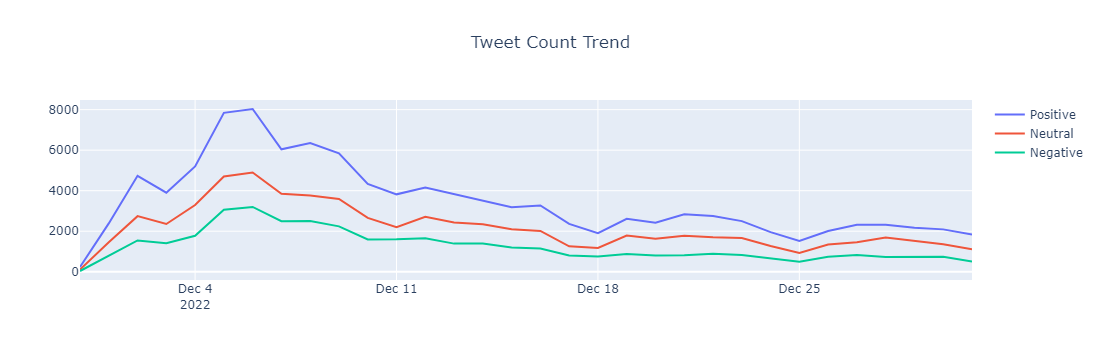

In [40]:
fig=go.Figure()
fig.add_trace(go.Scatter(x=datadatepos.index,y=datadatepos['sentiment_type'],name='Positive'))
fig.add_trace(go.Scatter(x=datadateneu.index,y=datadateneu['sentiment_type'],name='Neutral'))
fig.add_trace(go.Scatter(x=datadateneg.index,y=datadateneg['sentiment_type'],name='Negative'))
fig.update_layout(
    title={'text':"Tweet Count Trend",'y':0.9,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})
fig.show()

It can be observed that tweets count peeked 4-5 days after the launch of ChatGPT with positive tweets dominating the trend throughout the whole month.

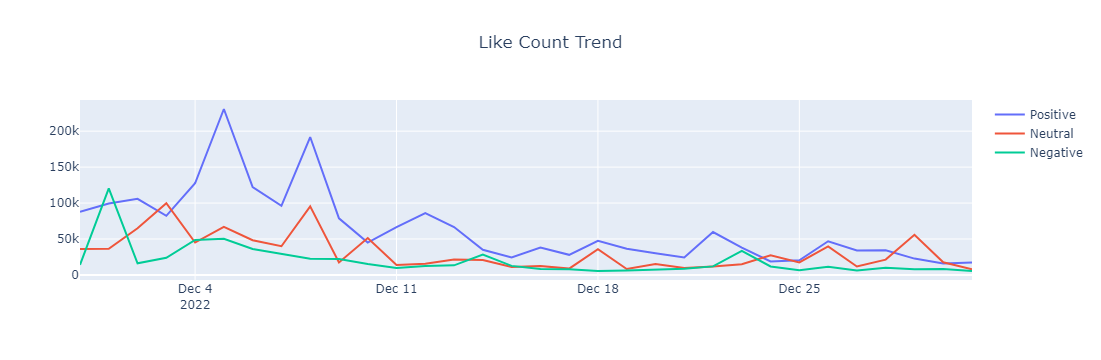

In [41]:
fig=go.Figure()
fig.add_trace(go.Scatter(x=datadatepos.index,y=datadatepos['like_count'],name='Positive'))
fig.add_trace(go.Scatter(x=datadateneu.index,y=datadateneu['like_count'],name='Neutral'))
fig.add_trace(go.Scatter(x=datadateneg.index,y=datadateneg['like_count'],name='Negative'))
fig.update_layout(
    title={'text':"Like Count Trend",'y':0.9,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})
fig.show()

Negative tweets gained more traction in terms of likes in the first few days of launch even though the number of negative tweets were the lowest in the same period.

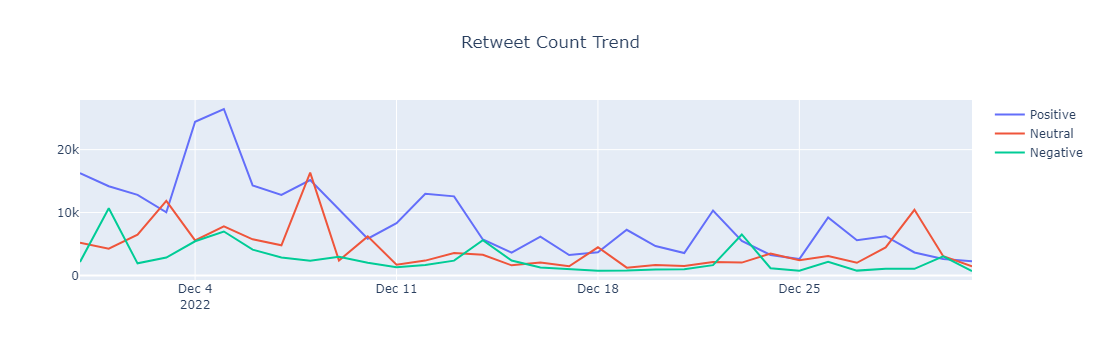

In [42]:
fig=go.Figure()
fig.add_trace(go.Scatter(x=datadatepos.index,y=datadatepos['retweet_count'],name='Positive'))
fig.add_trace(go.Scatter(x=datadateneu.index,y=datadateneu['retweet_count'],name='Neutral'))
fig.add_trace(go.Scatter(x=datadateneg.index,y=datadateneg['retweet_count'],name='Negative'))
fig.update_layout(
    title={'text':"Retweet Count Trend",'y':0.9,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})
fig.show()

To develop further trends, we resample again at the day level but the aggregation will be done by taking average.

In [43]:
datadateneu=datadate[datadate['sentiment_type']=='NEUTRAL']
datadateneu['sentiment_type']=1

datadateneg=datadate[datadate['sentiment_type']=='NEGATIVE']
datadateneg['sentiment_type']=1

datadatepos=datadate[datadate['sentiment_type']=='POSITIVE']
datadatepos['sentiment_type']=1

datadateneg=datadateneg.resample(rule='D').mean()
datadatepos=datadatepos.resample(rule='D').mean()
datadateneu=datadateneu.resample(rule='D').mean()

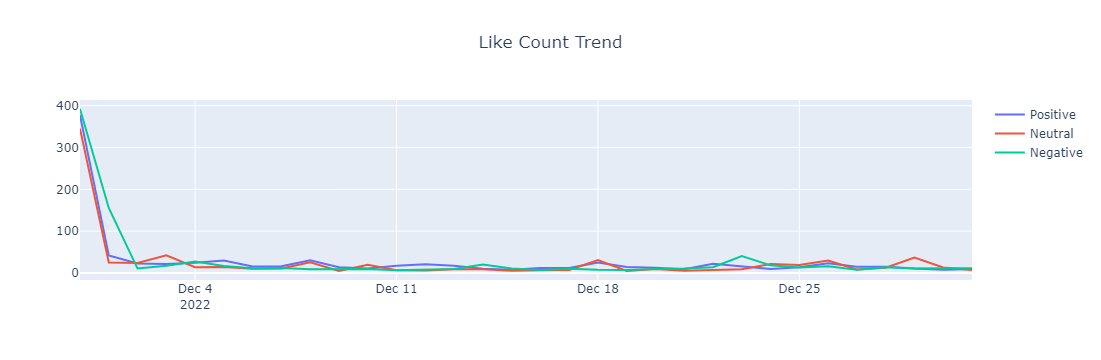

In [44]:
fig=go.Figure()
fig.add_trace(go.Scatter(x=datadatepos.index,y=datadatepos['like_count'],name='Positive'))
fig.add_trace(go.Scatter(x=datadateneu.index,y=datadateneu['like_count'],name='Neutral'))
fig.add_trace(go.Scatter(x=datadateneg.index,y=datadateneg['like_count'],name='Negative'))
fig.update_layout(
    title={'text':"Like Count Trend",'y':0.9,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})
fig.show()

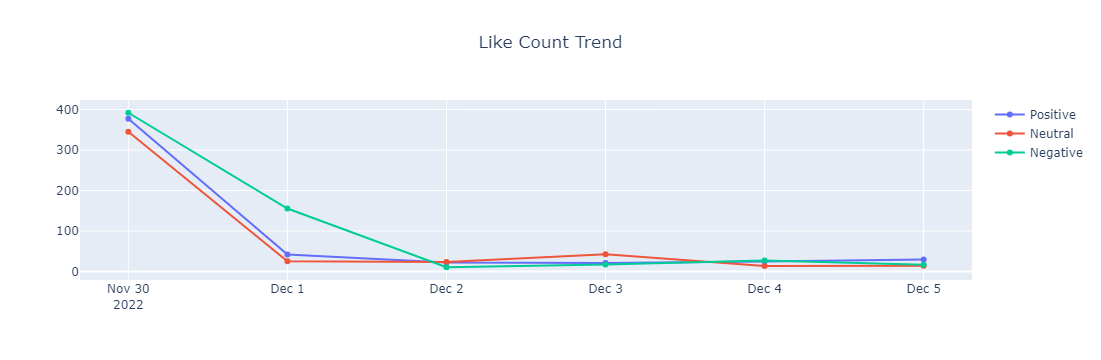

In [45]:
fig=go.Figure()
fig.add_trace(go.Scatter(x=datadatepos.index[:6],y=datadatepos['like_count'][:6],name='Positive'))
fig.add_trace(go.Scatter(x=datadateneu.index[:6],y=datadateneu['like_count'][:6],name='Neutral'))
fig.add_trace(go.Scatter(x=datadateneg.index[:6],y=datadateneg['like_count'][:6],name='Negative'))
fig.update_layout(
    title={'text':"Like Count Trend",'y':0.9,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})
fig.show()

At average level aggregation, it can be seen again that negative tweets gained more traction in terms of likes in the initial days if the release. 

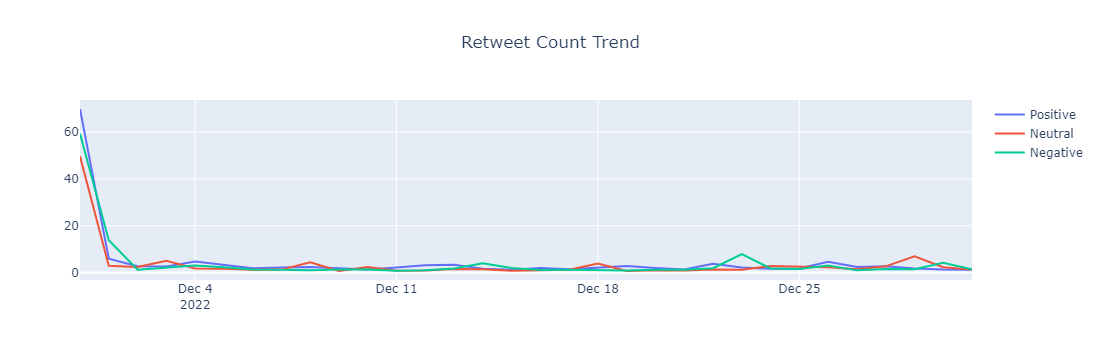

In [46]:
fig=go.Figure()
fig.add_trace(go.Scatter(x=datadatepos.index,y=datadatepos['retweet_count'],name='Positive'))
fig.add_trace(go.Scatter(x=datadateneu.index,y=datadateneu['retweet_count'],name='Neutral'))
fig.add_trace(go.Scatter(x=datadateneg.index,y=datadateneg['retweet_count'],name='Negative'))
fig.update_layout(
    title={'text':"Retweet Count Trend",'y':0.9,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})
fig.show()

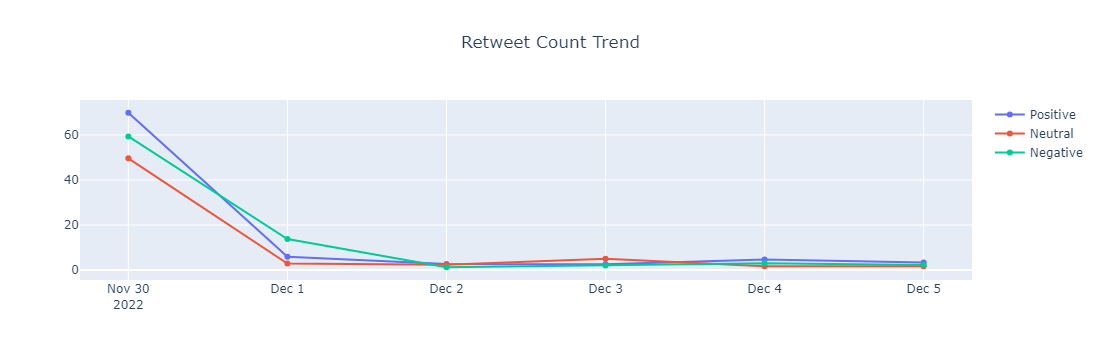

In [47]:
fig=go.Figure()
fig.add_trace(go.Scatter(x=datadatepos.index[:6],y=datadatepos['retweet_count'][:6],name='Positive'))
fig.add_trace(go.Scatter(x=datadateneu.index[:6],y=datadateneu['retweet_count'][:6],name='Neutral'))
fig.add_trace(go.Scatter(x=datadateneg.index[:6],y=datadateneg['retweet_count'][:6],name='Negative'))
fig.update_layout(
    title={'text':"Retweet Count Trend",'y':0.9,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})
fig.show()